# Comparing Markers

## Filtering the dataset

We need to filter the dataset to get rid of the unwanted markers. For this we extract some features from the dataset. 

### Pipeline:
1. Absolute Image: As the CH1 image has details above and below the noise floor, it is useful to set it up such that all values are above the noise floor. For this we plot the histogram and find the argmax to give us the noise floor intensity. We then center the intensity at this value and multiply the negative intensities with (-1). 
2. Noise Suppression: As there is a lot of background noise, we run the image through a gaussian blur filter with a sigma of 0.7. 
3. Maxima Counting: We use the H-maxima method to count the number of maxima in the image. We throw out all images with more than 1 maxima. This is a little aggressive but it works. 
4. Circularity and area: We also compute the area, perimeter and circularity of the image by passing it through an thresholding algorithm and then using standard methods. 

### Code: 
**Note:** Run this section only if maxima_dataset.npy and filtered_dataset.npy do not exist. This section takes a long time to run. 

In [ ]:
import numpy as np
from tqdm import tqdm,trange
from BioImage import BioImage, folders
import sys
from numpy.random import randint

dataset = np.array([])
for folder_idx, folder in enumerate(folders):
    
    print('Processing folder ' + folder + ':')
    sys.stdout.flush()
    for i in trange(0,10000):
        b = BioImage(folder, i)
        try: 
            features = b.getExtrema()
        except Exception as e: 
            print(e)
            b.showImage()
        data_line = np.insert(features, 0, [folder_idx, i])
        if dataset.size == 0:
            dataset = data_line
        else:
            dataset = np.vstack((dataset, data_line))

np.save('Maxima_dataset', dataset)

In [ ]:
dataset[0,:]

(4508, 11)


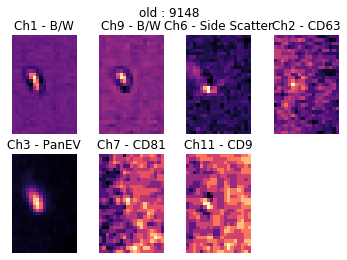

[ 1.          2.         13.         15.         11.41421356  1.44606865
 43.         29.41421356  0.62422853]
Counter({1.0: 2293, 0.0: 2215})
['old', 'young']


In [31]:
dataset = np.load('Maxima_dataset.npy')
features = np.load('dataset.npy')

#new_data = np.column_stack((dataset, features))
new_data = dataset
threshold = 5
# new_data[2 & 3] = number of maxima in ch1 and ch6
# new_data[4] = distance from edge
# new_Data[7] circularity in ch1
new_data = new_data[(new_data[:,2]<=2) 
                    & (new_data[:,3]<=2)] 
                    #& (new_data[:,4]>threshold)
                    #& (new_data[:,7]>0.5)
                    #& (new_data[:,7]<1.25)]
print(new_data.shape)


np.save('filtered_dataset', new_data)

index = randint(0,new_data.shape[0])

folder = folders[int(new_data[index,0])]

b = BioImage(folder, int(new_data[index,1]))
b.showImage()
features = b.getExtrema()
print (features)

import collections
a = collections.Counter(new_data[:,0])
print (a)
print (folders)

## Computing Activations: 

1. We load the filtered dataset and compute the activations based on thresholding and 

In [32]:
import numpy as np
from tqdm import tqdm,trange
from BioImage import BioImage, folders
import sys
from numpy.random import randint

data = np.load('filtered_dataset.npy')
activations = np.array([])
row_one = True
for row in tqdm(data):
    folder = folders[int(row[0])]
    index = int((row[1]))
    b = BioImage(folder, index)
    if row_one:
        #print(b.getActivations())
        activations = b.getActivations()
        row_one = False
    else:
        activations = np.vstack((activations, b.getActivations()))

    


100%|██████████| 4508/4508 [00:23<00:00, 189.64it/s]


In [33]:
data_activations = np.hstack((data,activations))

young = data_activations[(data_activations[:,0]==1)]
old = data_activations[(data_activations[:,0]==0)]
print(young.shape)
print(old.shape)
young_counts = np.sum(young[:,11:14], axis=0)
old_counts = np.sum(old[:,11:14], axis=0)

young_none = np.count_nonzero(~np.any(young[:,11:14], axis=1))
print (young_none)
old_none = np.count_nonzero(~np.any(old[:,11:14], axis=1))
print (old_none)
counts = np.vstack((young_counts, old_counts))
print(np.transpose(counts))

np.unique(data[:,0],return_counts=True)


(2293, 14)
(2215, 14)
6
3
[[2281. 2209.]
 [1128. 1264.]
 [ 777.  730.]]


(array([0., 1.]), array([2215, 2293]))

In [35]:
from scipy.stats import fisher_exact

young_total = young.shape[0]
old_total = old.shape[0]

contingency_ch2 = np.zeros((2,2))
contingency_ch2[0,0] = young_counts[0]
contingency_ch2[0,1] = old_counts[0]
contingency_ch2[1,0] = young_total - young_counts[0]
contingency_ch2[1,1] = old_total - old_counts[0]
print(contingency_ch2[1,0])

print ((contingency_ch2))
print (fisher_exact(contingency_ch2))

contingency_ch7 = np.zeros((2,2))
contingency_ch7[0,0] = young_counts[1]
contingency_ch7[0,1] = old_counts[1]
contingency_ch7[1,0] = young_total - young_counts[1]
contingency_ch7[1,1] = old_total - old_counts[1]

print ((contingency_ch7))
print (fisher_exact(contingency_ch7))

contingency_ch11 = np.zeros((2,2))
contingency_ch11[0,0] = young_counts[2]
contingency_ch11[0,1] = old_counts[2]
contingency_ch11[1,0] = young_total - young_counts[2]
contingency_ch11[1,1] = old_total - old_counts[2]

print ((contingency_ch11))
print (fisher_exact(contingency_ch11))

12.0
[[2281. 2209.]
 [  12.    6.]]
(0.5162969669533726, 0.23821547901991452)
[[1128. 1264.]
 [1165.  951.]]
(0.7284782963003206, 1.2573576081241025e-07)
[[ 777.  730.]
 [1516. 1485.]]
(1.0426184624281636, 0.5276990348216171)


old:3712


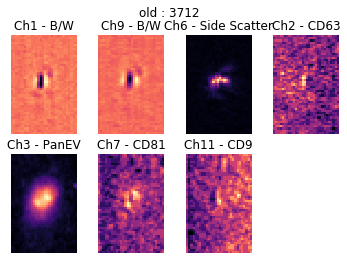

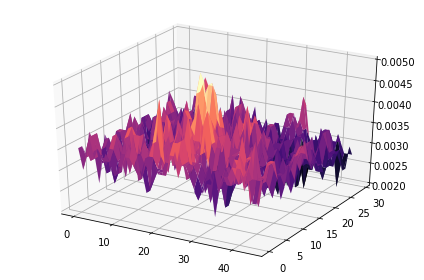

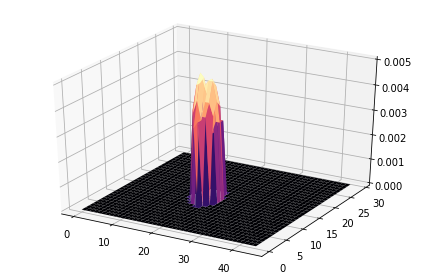

CD63 intensity0.1225


In [44]:
import numpy as np
from BioImage import BioImage, folders
from numpy.random import randint

data = np.load('filtered_dataset.npy')

point = randint(0,data.shape[0])


folder = int(data[point][0])
sample = int(data[point][1])

print(folders[folder] + ':' + str(sample))

b = BioImage(folders[folder], sample)
b.showImage()
b.show3D(b.ch2)
mask = b.getThresholded(b.ch1)
b.show3D(np.multiply(mask,b.ch2))

ch2 = np.sum(np.multiply(mask, b.ch2))
ch4 = np.sum(np.multiply(mask, b.ch3))
print('CD63 intensity' + str(ch2))